# 🏭 Ingeniería de S&OP: De la Intuición a la Estadística
**Autor:** **Datalaria**

Este notebook acompaña al artículo sobre higiene de datos en la Cadena de Suministro.
Aquí simularemos un escenario real: la recepción de un archivo de ventas "sucio" (típico de un Excel manual o exportación de ERP legacy) y aplicaremos **Ingeniería de Datos** para limpiar la señal antes de usarla para predicción de demanda.

**Objetivos:**
1. Generar datos caóticos (Outliers, errores de fecha, nulos).
2. Aplicar un pipeline de limpieza con Python (Pandas + Scipy).
3. Visualizar el impacto: "Ruido vs Señal".

In [1]:
!pip install supabase pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 8.6 MB/s eta 0:00:00


In [2]:
# @title 1. Generar Escenario de Datos (Simulación)
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Configuración del escenario
ROWS = 200
OUTLIER_MAGNITUDE = 50000  # Venta gigante errónea
N_OUTLIERS = 5             # Cantidad de errores graves

print("🎲 Generando datos de ventas simulados con errores intencionales...")

# 1. Base de datos limpia (Tendencia con algo de ruido normal)
dates = [datetime(2024, 1, 1) + timedelta(days=x) for x in range(ROWS)]
base_qty = np.random.normal(loc=100, scale=20, size=ROWS) # Media 100, Desv 20
base_qty = np.maximum(base_qty, 0) # No ventas negativas

df = pd.DataFrame({'date': dates, 'qty': base_qty, 'product_id': 'SKU-001'})

# 2. Inyección de "Suciedad" (Errores de la vida real)

# A) Fechas corruptas (Texto en vez de fecha)
for _ in range(5):
    idx = random.randint(0, ROWS-1)
    df.at[idx, 'date'] = "FECHA_PENDIENTE"

# B) Valores Nulos (Gente que se olvidó rellenar la celda)
for _ in range(5):
    idx = random.randint(0, ROWS-1)
    df.at[idx, 'qty'] = np.nan

# C) Outliers Masivos (El "Dedo gordo" en Excel: 50000 en vez de 50)
outlier_indices = random.sample(range(ROWS), N_OUTLIERS)
for idx in outlier_indices:
    df.at[idx, 'qty'] = OUTLIER_MAGNITUDE + random.uniform(0, 1000)

print(f"✅ Dataset generado: {len(df)} filas.")
print("Muestra de datos sucios:")
display(df.iloc[outlier_indices].head(3)) # Mostramos los errores

🎲 Generando datos de ventas simulados con errores intencionales...
✅ Dataset generado: 200 filas.
Muestra de datos sucios:


/tmp/ipython-input-3026521070.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'FECHA_PENDIENTE' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.at[idx, 'date'] = "FECHA_PENDIENTE"


,date,qty,product_id
172,2024-06-21 00:00:00,50155.015651,SKU-001
90,2024-03-31 00:00:00,50261.475702,SKU-001
63,2024-03-04 00:00:00,50819.277903,SKU-001


In [3]:
# @title 2. El Motor de Limpieza (The Code)
from scipy import stats

class SupplyChainSanitizer:
    """
    Clase responsable de auditar y limpiar los datos de entrada.
    Aplica:
    1. Higiene Estructural (Tipos de datos, Nulos)
    2. Higiene Estadística (Detección de Outliers con Z-Score)
    """
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.report = {"initial_rows": len(dataframe)}

    def structural_clean(self):
        # 1. Coerción de Fechas (Lo que no es fecha, se vuelve NaT)
        self.df['date'] = pd.to_datetime(self.df['date'], errors='coerce')

        # 2. Coerción de Numéricos
        self.df['qty'] = pd.to_numeric(self.df['qty'], errors='coerce')

        # 3. Eliminar basura (Filas donde no hay fecha o cantidad válida)
        self.df = self.df.dropna(subset=['date', 'qty'])

        return self

    def detect_outliers_zscore(self, threshold=3):
        # Cálculo de Z-Score (Desviaciones estándar desde la media)
        # Se calcula sobre los datos limpios estructuralmente
        self.df['z_score'] = np.abs(stats.zscore(self.df['qty']))

        # Marcamos como outlier si supera el umbral (ej: 3 sigmas)
        self.df['is_outlier'] = self.df['z_score'] > threshold
        return self

    def get_clean_data(self):
        return self.df

print("✅ Clase 'SupplyChainSanitizer' cargada en memoria.")

✅ Clase 'SupplyChainSanitizer' cargada en memoria.


In [4]:
# @title 3. Ejecutar Pipeline
print("⚙️ Procesando datos...")

sanitizer = SupplyChainSanitizer(df)
clean_df = sanitizer.structural_clean().detect_outliers_zscore().get_clean_data()

# Métricas
total_outliers = clean_df['is_outlier'].sum()
rows_dropped = len(df) - len(clean_df)

print(f"""
📊 REPORTE DE AUDITORÍA:
-----------------------
Filas originales:      {len(df)}
Filas eliminadas (Estructura): {rows_dropped}
Outliers detectados (Estadística): {total_outliers}
-----------------------
Datos listos para análisis: {len(clean_df)}
""")

⚙️ Procesando datos...

📊 REPORTE DE AUDITORÍA:
-----------------------
Filas originales:      200
Filas eliminadas (Estructura): 10
Outliers detectados (Estadística): 5
-----------------------
Datos listos para análisis: 190



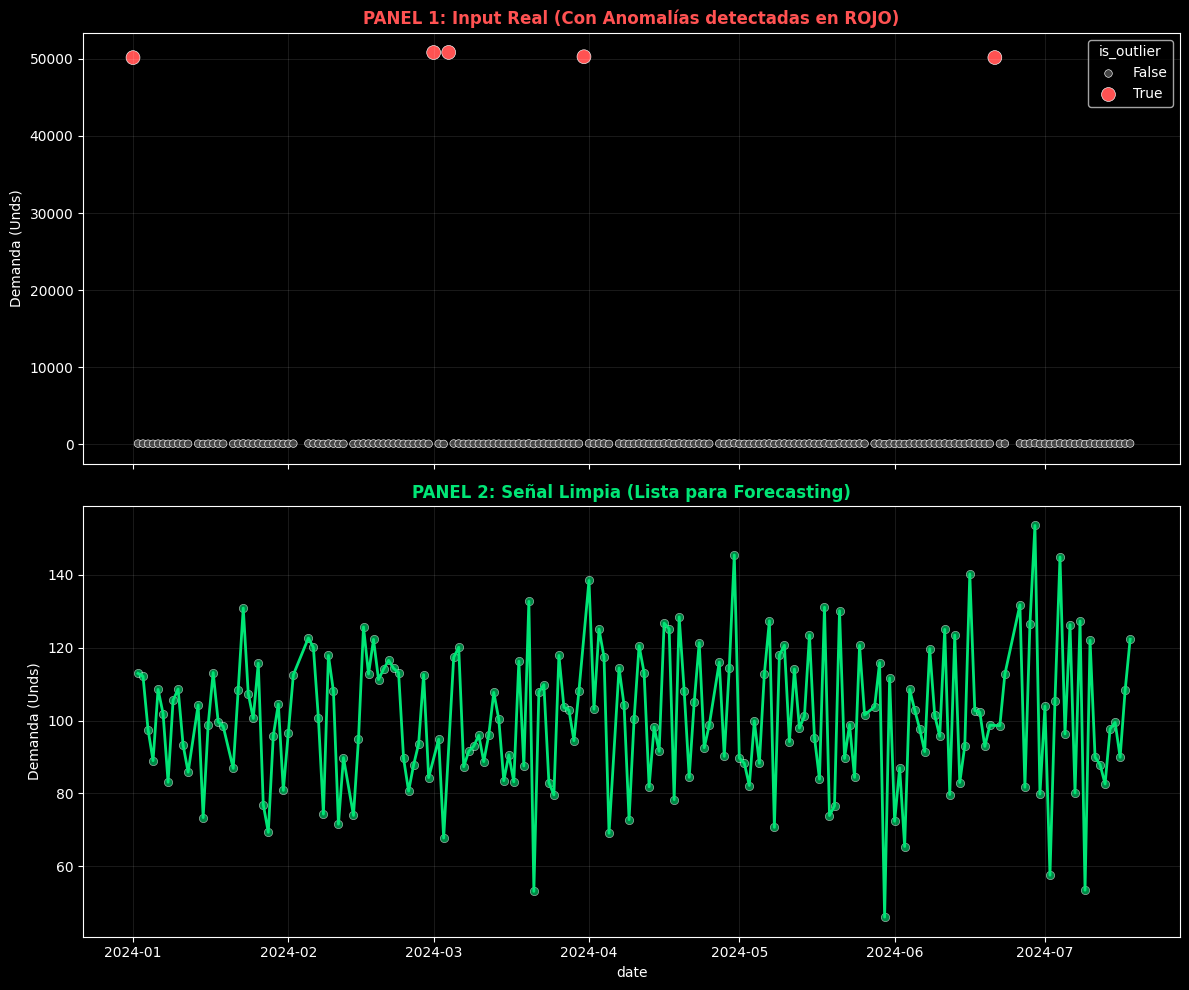

In [5]:
# @title 4. Visualización: Ruido vs Señal
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# PANEL 1: REALIDAD (Datos Sucios)
# Graficamos el DF limpio pero INCLUYENDO los outliers marcados
sns.scatterplot(data=clean_df, x='date', y='qty', ax=ax1,
                hue='is_outlier', palette={False: '#444', True: '#ff5252'},
                size='is_outlier', sizes={False: 30, True: 100}, legend='full')

ax1.set_title('PANEL 1: Input Real (Con Anomalías detectadas en ROJO)', color='#ff5252', fontweight='bold')
ax1.set_ylabel('Demanda (Unds)')
ax1.grid(True, alpha=0.1)

# PANEL 2: VISIÓN DE INGENIERÍA (Datos Filtrados)
# Filtramos los outliers para ver la señal
final_signal = clean_df[clean_df['is_outlier'] == False]

sns.lineplot(data=final_signal, x='date', y='qty', ax=ax2, color='#00e676', linewidth=2)
sns.scatterplot(data=final_signal, x='date', y='qty', ax=ax2, color='#00e676', alpha=0.6)

ax2.set_title('PANEL 2: Señal Limpia (Lista para Forecasting)', color='#00e676', fontweight='bold')
ax2.set_ylabel('Demanda (Unds)')
ax2.grid(True, alpha=0.1)

plt.tight_layout()
plt.show()